# <center> <b> <font color='blue'> AIR QUALITY </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Models](#5)
6. [References](#References)

<a name="1"></a>
## <font color='#2e86c1'> <b> 1. Problem Statement </font> </b>

We want to study a multivariate time series problem.

<a name="2"></a>
## <font color='#2e86c1'> <b> 2. Setup </font> </b>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

In [74]:
@dataclass
class G:
    WINDOW_SIZE = 30 # one month
    HORIZON = 1
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8

<a name="3"></a>
## <font color='#2e86c1'> <b> 3. Helper Functions </font> </b>

### Plots

In [39]:
def plot_time_series(time, series, title, xlabel, ylabel, label):
    """
    Plot time series
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time, series, label=label, color='blue')

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    # Set custom ticks on the x-axis
    # Choose the indices or specific timestamps you want to mark
    tick_indices = np.arange(0, len(time), 100)  # Example: every 100th index
    plt.xticks(ticks=time[tick_indices], rotation=45)  # Rotate for better visibility

    plt.tight_layout()  # Adjust layout to make room for tick labels
    plt.show()
    
    
def plot_features_vs_target(data):
    """
    Plots the features against the target
    """
    # Assuming data shape is (num_samples, 6) where the first column is temperature
    temperature = data[:, 0]

    # Create scatter plots for each feature against temperature
    plt.figure(figsize=(15, 10))

    for i in range(1, data.shape[1]):  # Start from 1 to skip the temperature column
        plt.subplot(3, 2, i)  # Adjust the layout based on the number of features
        plt.scatter(data[:, i], temperature, alpha=0.5)
        plt.title(f'Feature {i} vs Temperature')
        plt.xlabel(f'Feature {i}')
        plt.ylabel('Temperature')

    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    # Assuming `history` is the output from model.fit()
    # Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation MSE
    plt.subplot(1, 2, 2)  # One row, two columns, second subplot
    plt.plot(history.history['mse'], label='Training MSE')
    if 'val_mse' in history.history:
        plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

### Train/Test split

In [5]:
def train_test_split_time_series(data, split_size=G.SPLIT_SIZE):
    """Splits a multivariate time series into training and testing sets, ensuring temporal order.

    Args:
        data: numpy array
        spli_size (float, optional): Proportion of data to be used for training.

    Returns:
        tuple: A tuple containing the training and testing sets.
    """

    # Determine the split point based on the test size
    split_point = int(len(data) * split_size)

    # Split the data into training and testing sets, preserving time order
    train_data = data[:split_point]
    test_data = data[split_point:]

    return train_data, test_data

### Windowing

In [6]:
def windowed_dataset(data, window_size, batch_size, shuffle_buffer, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create sliding windows of size window_size + 1 (for the label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset and create feature/label pairs
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Features: previous 5 values of both T and h (columns 0 and 1 respectively)
    # Target: next temperature value (T at t+1, column 0 of the last row in the window)
    dataset = dataset.map(lambda window: (window[:-1, :], window[-1, 0]))  
            # 'window[:-1, :]' gets 5 values of T and the others features, 'window[-1, 0]' gets T(t+1)
    
    # Shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


### Predictions

In [51]:
def forecast(model, initial_window, num_predictions, horizon=G.HORIZON):
    """
    Forecast future values using a model with multi-step horizon predictions.
    
    Args:
        model: The trained model used for predictions.
        initial_window: The starting data window.
        num_predictions: The total number of steps to predict.
        horizon: The number of steps the model predicts in each iteration (e.g., 2 for 2 steps ahead).

    Returns:
        A NumPy array of predicted values.
    """
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window
    

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for multiple steps ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_steps = pred[0][:horizon]  # Extract the predicted steps

        # Add the predictions to the list, but ensure we don't exceed num_predictions
        steps_to_add = min(horizon, num_predictions - len(predictions))
        predictions.extend(pred_steps[:steps_to_add])
        
        # Update the window: remove the oldest values and add the new predictions
        current_window = np.roll(current_window, -steps_to_add)  # Shift left by the number of steps added
        current_window[-steps_to_add:] = pred_steps[:steps_to_add]  # Insert the new predictions at the end

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values

### Evaluation

In [58]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
 
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

<a name="4"></a>
## <font color='#2e86c1'> <b> 4. Loading and pre-processing data </font> </b>

DATASET


Vito, S. (2008). Air Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.


https://archive.ics.uci.edu/dataset/360/air+quality

### Dataset info

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2)  and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. 

Missing values are tagged with -200 value.


### Loading data

In [75]:
# Load the dataset
df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']], 
                 na_values=-200)

# Drop the unnamed columns and rows with NaN values
df_clean = df.drop(columns=['Unnamed: 15', 'Unnamed: 16']).dropna()

# Set the Date_Time as the index
df_clean = df_clean.set_index('Date_Time')

# Select the relevant features and the target variable
df_filtered = df_clean[['T', 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'RH', 'AH']]

In [76]:
df_filtered.head()

,T,CO(GT),NMHC(GT),C6H6(GT),RH,AH
Date_Time,,,,,,
10/03/2004 18.00.00,13.6,2.6,150.0,11.9,48.9,0.7578
10/03/2004 19.00.00,13.3,2.0,112.0,9.4,47.7,0.7255
10/03/2004 20.00.00,11.9,2.2,88.0,9.0,54.0,0.7502
10/03/2004 21.00.00,11.0,2.2,80.0,9.2,60.0,0.7867
10/03/2004 22.00.00,11.2,1.6,51.0,6.5,59.6,0.7888


We want to predict temperature given the other values, therefore D=5 (the number of features is 5).

In [77]:
df_filtered.shape

(827, 6)

In [78]:
time = df_filtered.index.values
time[-2:]

array(['30/04/2004 23.00.00', '01/05/2004 00.00.00'], dtype=object)

In [79]:
# Convert dataframe to NumPy array for TensorFlow compatibility
data = df_filtered.values

### Visualization

Remember

data[:, 0] refers to the first column of the array (Temperature, which in this case is the target)

data[:, 1] refers to the second column (CO(GT))

data[:, 2] refers to the third column.

data[:, 3] refers to the fourth column.

data[:, 4] refers to the fifth column.

data[:, 5] refers to the sixth column.

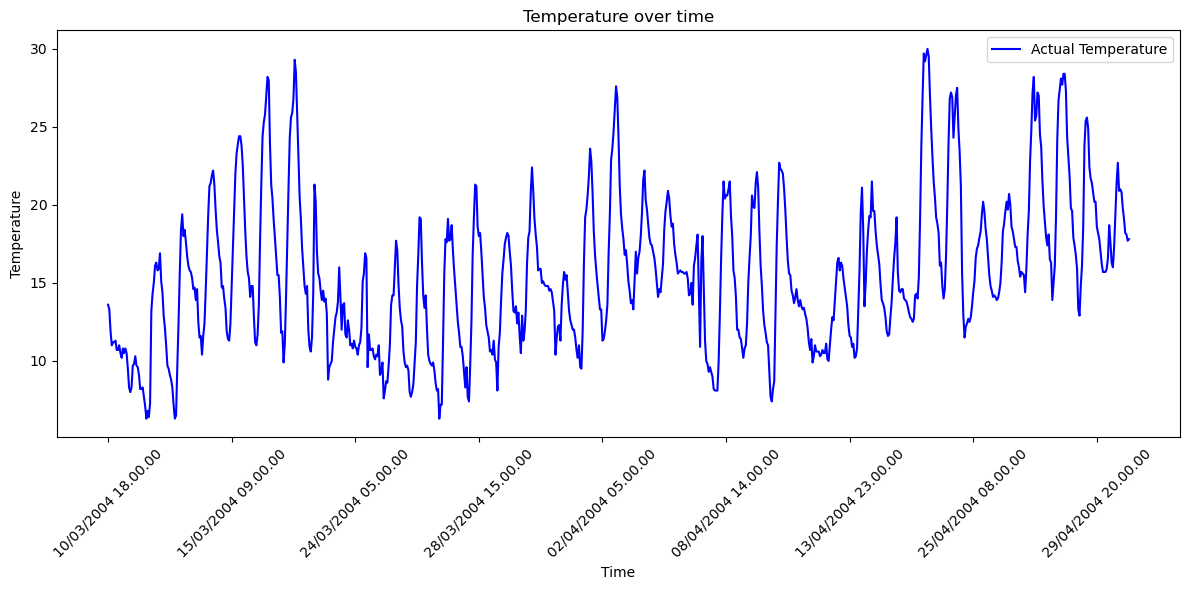

In [80]:
plot_time_series(time, data[:, 0], 'Temperature over time' ,'Time', 'Temperature', 'Actual Temperature')    

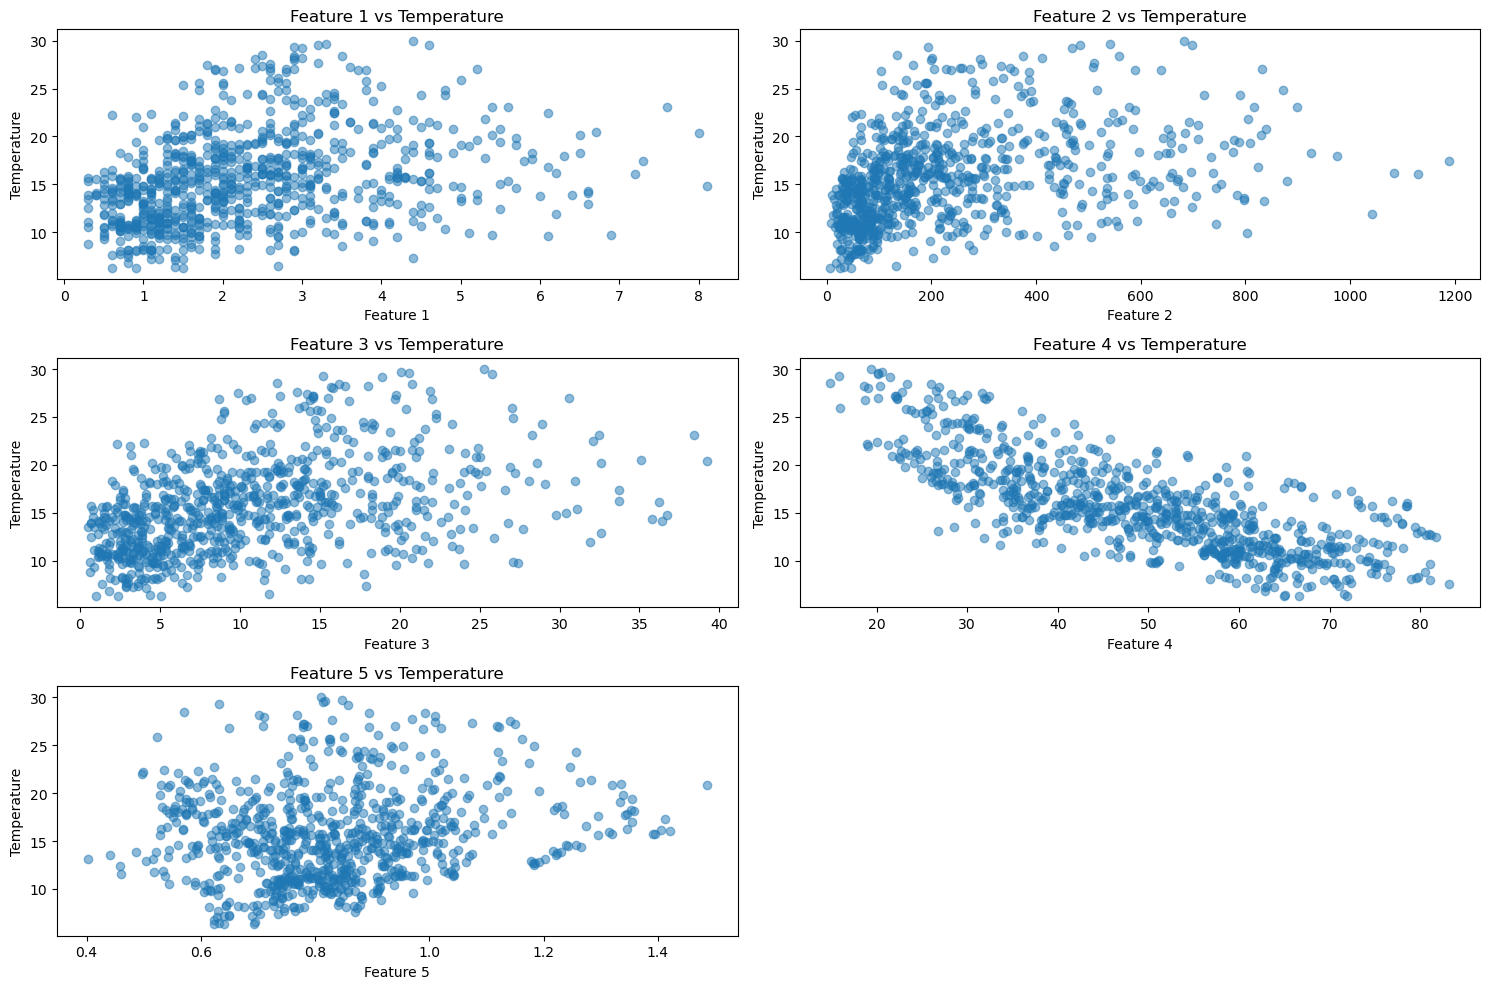

In [81]:
plot_features_vs_target(data)

### Correlation matrix

In [82]:
# Calculate the correlation matrix
correlation_matrix = df_filtered.corr()

# Print the entire correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 T    CO(GT)  NMHC(GT)  C6H6(GT)        RH        AH
T         1.000000  0.318261  0.366976  0.418409 -0.769869  0.159964
CO(GT)    0.318261  1.000000  0.887167  0.972660 -0.105157  0.295591
NMHC(GT)  0.366976  0.887167  1.000000  0.897928 -0.160257  0.282142
C6H6(GT)  0.418409  0.972660  0.897928  1.000000 -0.178410  0.313415
RH       -0.769869 -0.105157 -0.160257 -0.178410  1.000000  0.475776
AH        0.159964  0.295591  0.282142  0.313415  0.475776  1.000000


**T (target) correlations:**

- T has moderate positive correlations with C6H6(GT) (0.418), NMHC(GT) (0.367), and CO(GT) (0.318). These correlations suggest that as the levels of these pollutants increase, the temperature tends to increase as well.

- T has a strong negative correlation with RH (-0.770). This means that as relative humidity (RH) increases, the temperature tends to decrease significantly.

- The correlation between T and AH (absolute humidity) is weaker, but still positive (0.160), implying a slight tendency for temperature to increase with higher absolute humidity.


**Feature correlations:**

- CO(GT), NMHC(GT), and C6H6(GT) are highly correlated with each other (CO(GT) and C6H6(GT) have a correlation of 0.973, for example). This indicates multicollinearity, meaning these variables might be capturing similar underlying information, likely related to pollution levels.

- RH has a weak negative correlation with the pollutant features (CO(GT), NMHC(GT), and C6H6(GT)), suggesting that higher humidity levels are associated with slightly lower pollution levels.

- AH has moderate positive correlations with the pollutants, particularly with C6H6(GT) (0.313) and CO(GT) (0.296), indicating that absolute humidity might be related to pollution

**Summary**

- The strongest correlation with the target T is the negative relationship with RH (-0.770). This suggests that humidity plays a significant role in lowering temperature.

- Pollutant levels (CO(GT), NMHC(GT), C6H6(GT)) are positively correlated with temperature but to a moderate degree. They are also highly intercorrelated, which may suggest that in a model, using all of them might not add much additional information.

- AH has a minor positive correlation with temperature and moderate correlations with the pollutants, but it is less impactful than RH.

<font color='red'> <b> Important note: </b></font>  In this notebook, since what we are really interested in is working with a multivariate time series, we are going to keep all the features. 

### Train/test split

In [83]:
train_data, val_data = train_test_split_time_series(data)

In [84]:
train_data.shape, val_data.shape

((661, 6), (166, 6))

### Windowing

Let's test our windowing function with a window size of 2 and a batch_size=1 to see more clearly what it does.

In [85]:
aux = windowed_dataset(train_data, 2, 1, G.SHUFFLE_BUFFER_SIZE, False)

In [86]:
# first rows of the original data
train_data[:5]

array([[ 13.6   ,   2.6   , 150.    ,  11.9   ,  48.9   ,   0.7578],
       [ 13.3   ,   2.    , 112.    ,   9.4   ,  47.7   ,   0.7255],
       [ 11.9   ,   2.2   ,  88.    ,   9.    ,  54.    ,   0.7502],
       [ 11.    ,   2.2   ,  80.    ,   9.2   ,  60.    ,   0.7867],
       [ 11.2   ,   1.6   ,  51.    ,   6.5   ,  59.6   ,   0.7888]])

In [87]:
for x, y in aux.take(3):
    print(f"X: {x}\n y: {y} \n\n")

X: [[[ 13.6      2.6    150.      11.9     48.9      0.7578]
  [ 13.3      2.     112.       9.4     47.7      0.7255]]]
 y: [11.9] 


X: [[[ 13.3      2.     112.       9.4     47.7      0.7255]
  [ 11.9      2.2     88.       9.      54.       0.7502]]]
 y: [11.] 


X: [[[11.9     2.2    88.      9.     54.      0.7502]
  [11.      2.2    80.      9.2    60.      0.7867]]]
 y: [11.2] 




Now let's apply this function to the train and validation sets with the data defined in the dataclass G.

In [88]:
ds_train = windowed_dataset(train_data, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, True)
ds_val = windowed_dataset(val_data, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, False)

<a name="#1a5276"></a>
## <font color='#2e86c1'> <b> 5. Models </b> </font> 

Let's test a couple of models.

In [89]:
num_features = data.shape[1]
num_features

6

<a name="5.1"></a>
### <font color='#2471a3'> <b> 5.1. Dense Model </font> </b>

In [90]:
def build_compile_model_1(name, window_size=G.WINDOW_SIZE, num_features=num_features, horizon=G.HORIZON):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(window_size, num_features)),  
                    # input_shape should match your features
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(horizon)
    ], name=name)
    
    model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mse']
    )
    
    return model


model_1 = build_compile_model_1('Dense_Model')
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30, 64)            448       
                                                                 
 dense_13 (Dense)            (None, 30, 32)            2080      
                                                                 
 flatten_4 (Flatten)         (None, 960)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 961       
                                                                 
Total params: 3489 (13.63 KB)
Trainable params: 3489 (13.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
# fit
history_1 = model_1.fit(
    ds_train, 
    epochs=50, 
    verbose=0,
    validation_data=ds_val)

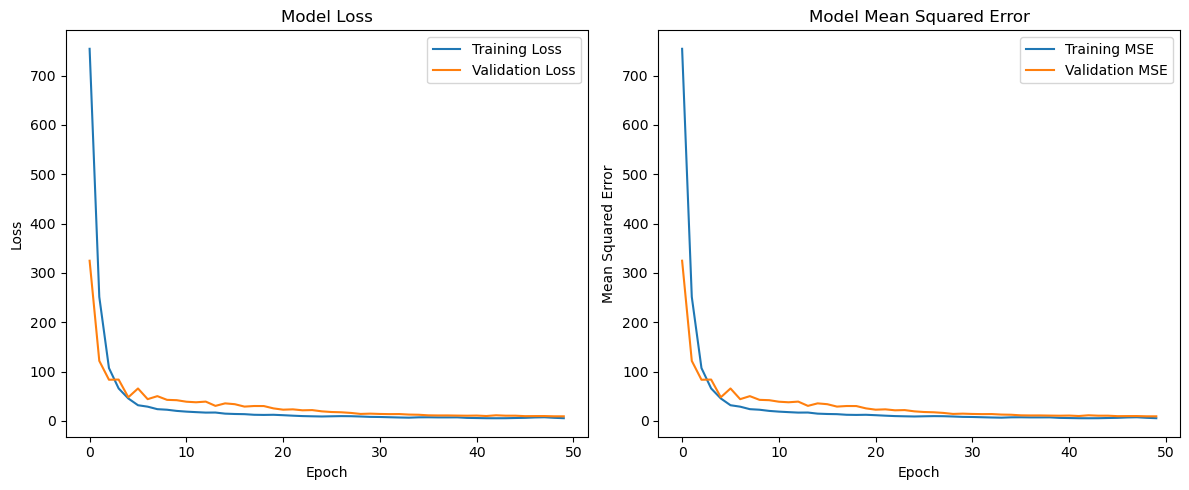

In [92]:
plot_history(history_1)

Let's make a prediction. Our window size is 30. For simplicity we are going to use part of the validation data.

In [98]:
x_pred = val_data[44:74]

x_pred.shape


(30, 6)

In [99]:
x_pred[np.newaxis].shape

(1, 30, 6)

In [100]:
model_1.predict(x_pred[np.newaxis])

1/1 [==============================] - 0s 16ms/step


array([[15.795723]], dtype=float32)

Let's make predictions.

In [93]:
preds_model_1 = forecast(model_1, data[-G.WINDOW_SIZE:], val_data.shape[0])

In [94]:
preds_model_1.shape

(166,)

In [95]:
# remeber temperature is val_data[:,0]
model_2_results = evaluate_preds(val_data[:,0], preds_model_1)
model_2_results

{'mae': 54.97742, 'mse': 3731.546, 'rmse': 61.08638, 'mape': 300.17648}

<a name="5.2"></a>
### <font color='#2471a3'> <b> 5.2. LSTM </font> </b>

In [106]:
def build_compile_model_2(name, window_size=G.WINDOW_SIZE, num_features=num_features, horizon=G.HORIZON):
    model = tf.keras.Sequential(name=name)

    # LSTM Layer to handle time series input
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, num_features)))
    model.add(tf.keras.layers.LSTM(64))

    # Dense layer to output the final temperature prediction
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(horizon))

    # Compile the model
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])

    return model


model_2 = build_compile_model_2('LSTM')
model_2.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 64)            18176     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 53313 (208.25 KB)
Trainable params: 53313 (208.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
# fit
history_2 = model_2.fit(
    ds_train, 
    epochs=50, 
    verbose=0,
    validation_data=ds_val)

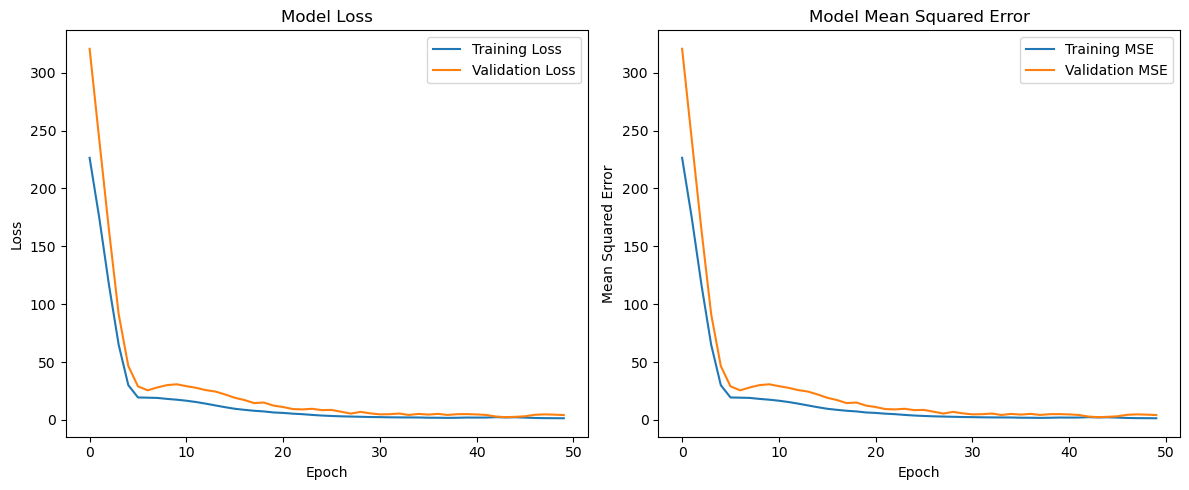

In [108]:
plot_history(history_2)

In [109]:
model_2.predict(x_pred[np.newaxis])

1/1 [==============================] - 1s 519ms/step


array([[14.892185]], dtype=float32)

In [110]:
preds_model_2 = forecast(model_2, data[-G.WINDOW_SIZE:], val_data.shape[0])

In [112]:
# remeber temperature is val_data[:,0]
model_2_results = evaluate_preds(val_data[:,0], preds_model_2)
model_2_results

{'mae': 4.429334, 'mse': 33.458748, 'rmse': 5.7843537, 'mape': 22.80224}

<a name="References"></a>
## <font color='#1a5276'> <b> 6. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)

In [133]:
def plot_comparison(time, true_values, preds):
    plt.figure(figsize=(10, 5))  # Optional: Set the figure size
    plt.plot(time, preds, label='Preds', color='blue')  # Plot the first array
    plt.plot(time, true_values, label='True', color='orange')  # Plot the second array

    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Series')
    plt.title('True vs pred')
    plt.legend()  # Show legend
    plt.grid(True)  # Optional: Add a grid


    # Set x-ticks to show only specific labels
    plt.xticks(np.arange(0, 200, 50))

    # Show the plot
    plt.show()

In [134]:
index_array = df_filtered.index.to_numpy()

In [135]:
index_array[:3]

array(['10/03/2004 18.00.00', '10/03/2004 19.00.00',
       '10/03/2004 20.00.00'], dtype=object)

In [136]:
split_point = int(len(index_array) * G.SPLIT_SIZE)

# Split the data into training and testing sets, preserving time order
train_time = index_array[:split_point]
test_time = index_array[split_point:]

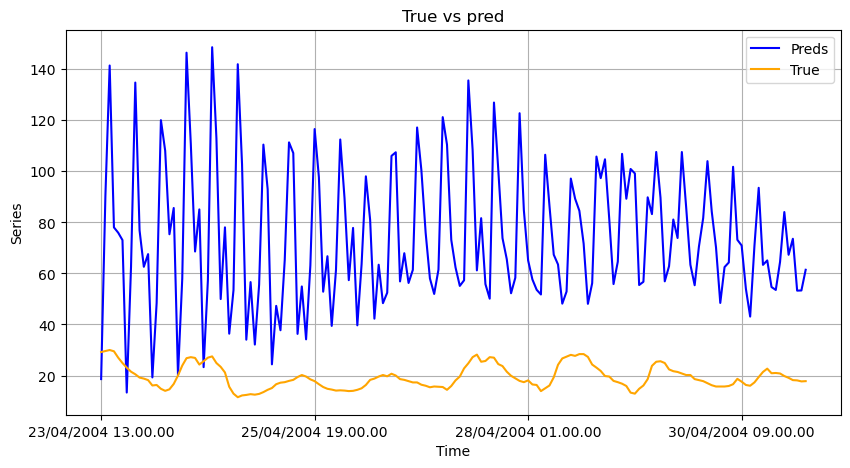

In [137]:
plot_comparison(test_time, val_data[:,0], preds_model_1)

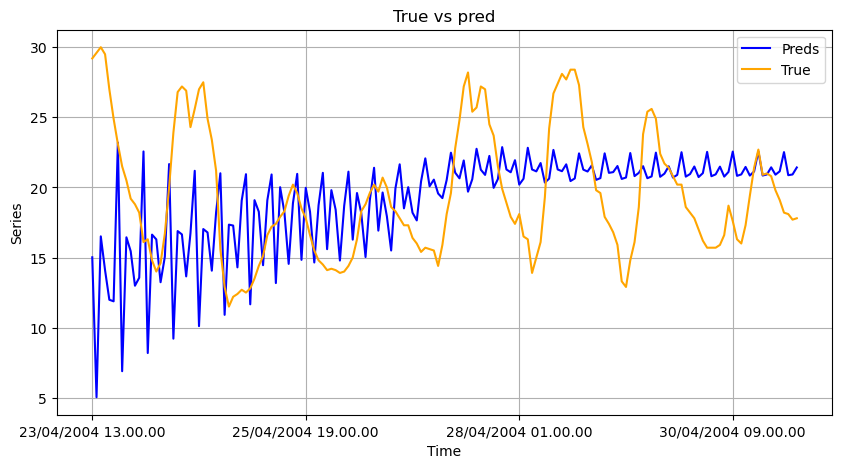

In [140]:
plot_comparison(test_time, val_data[:,0], preds_model_2)

In [143]:
val_data[:,0].shape, preds_model_2.shape

((166,), (166,))